# Installation
Please follow the instructions on README.mk file for installing the necessary packages to run this notebook

This walkthrough has few instructions. It's mainly just code to help the user to understand the pytorch geometric to hls4ml pipeline. If there's any confusion, please email me at yun79@purdue.edu

### Imports

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import sys
import yaml
import argparse
import numpy as np
import torch
import torch.nn as nn

from hls4ml.utils.config import config_from_pyg_model
from hls4ml.converters import convert_from_pyg_model
import hls4ml

from collections import OrderedDict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# locals
# from utils.models.bv_interaction_network_pyg import BvGENConvBig
from utils.models.bv_interaction_network_pyg_v2 import BvGENConvBig, convertBvToTorch
from model_wrappers import model_wrapper
from utils.data.dataset_pyg import GraphDataset
from utils.data.fix_graph_size import fix_graph_size
import time
import pickle as pkl
from Tau3MuGNNs.src.models.bv_model import convertBnToBvbn

from Tau3MuGNNs.src.utils import Criterion, Tau3MuDataset, log_epoch, load_checkpoint, get_data_loaders, add_cuts_to_config
from tqdm import tqdm
from pathlib import Path

handler args: ('NodeBlock',)
handler args: ('EdgeAggregate',)
handler args: ('ResidualBlock',)
handler args: ('NodeEncoder',)
handler args: ('EdgeEncoder',)
handler args: ('NodeEncoderBatchNorm1d',)
handler args: ('EdgeEncoderBatchNorm1d',)
handler args: ('MeanPool',)
handler args: ('fc_out',)
handler args: ('BvNodeEncoderBatchNorm1d',)
handler args: ('BvEdgeEncoderBatchNorm1d',)


In [3]:
Tau3MuDataset

Tau3MuGNNs.src.utils.dataset.Tau3MuDataset

### PyTorch Model

In [4]:
"""
We intialize our custom pytorch geometric(pyg) model
"""
config = {
    "bn_input": True,                 # Batch normalization on input features? This is to normalize the input features
  "n_layers": 8    ,                # Number of GNN layers
  "out_channels": 128  ,            # Number of hidden channels for each GNN layer
  "dropout_p": 0  ,               # Dropout probability
  "readout": "pool"  ,                # Specify the method to use for the readout layer. One can also use 'lstm', 'vn' or 'jknet'
  "norm_type": "batch"   ,            # Specify the type of normalization to use. One can also use 'instance', 'layer' or 'graph'
  "deepgcn_aggr": "sum"  ,        # Aggregation function for the DeeperGCN layers. Please refer to their documentation for more details
  "linear_ap_fixed_int": 4,
  "linear_ap_fixed_fract": 4,
  "norm_ap_fixed_int": 4 ,
  "norm_ap_fixed_fract": 4 ,
}

bebugging = True

intermediary_model = BvGENConvBig(
    config["n_layers"], 
    flow = "source_to_target",
    out_channels = 128,
    int_bitwidth = config["norm_ap_fixed_int"],
    fractional_bitwidth = config["norm_ap_fixed_fract"],
    debugging = bebugging
).eval() # eval mode for bathnorm


scale: 0.0625
min_val: -8.0
max_val: 7.9375


In [5]:
# saved_model_path = "Tau3MuGNNs/data/logs/12_15_2022_14_04_19-GNN_full_test/model.pt"
# state_dict = torch.load(saved_model_path, map_location="cpu")
# model_state_dict = state_dict["model_state_dict"]
# print("hello")

In [6]:
"""
check whether the state dict loads well
on the bv model
"""
from Tau3MuGNNs.src.models import BV_Model
import torch


x_dim = 3
edge_attr_dim = 4

bv_model = BV_Model(x_dim, edge_attr_dim, True, config, debugging = bebugging).eval()
bv_model = convertBnToBvbn(bv_model)

"""
We obtain the state dict(trained parameters) from a saved pt file
"""
# saved_model_path = "./model.pt"
saved_model_path = "Tau3MuGNNs/data/logs/12_15_2022_14_04_19-GNN_full_test/model.pt"
state_dict = torch.load(saved_model_path, map_location="cpu")
bv_model.load_state_dict(state_dict['model_state_dict'])



bv model is being used
scale: 0.0625
min_val: -8.0
max_val: 7.9375
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375
self.eps: 1e-07
scale: 0.0625
min_val: -8.0
max_val: 7.9375


<All keys matched successfully>

In [7]:
# intermediary_model.node_encoder_norm.state_dict()
node_encoder_norm = intermediary_model.node_encoder_norm
print(node_encoder_norm.norm.weight)
print(node_encoder_norm.norm.bias)


Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [8]:
# print(type(bv_model.mlps[0][1]) == nn.BatchNorm1d)
print(bv_model.mlps[0][1].__class__.__name__)

BatchNorm1dToQuantScaleBias


In [9]:
quant_weight = bv_model.mlps[0][1].quant_weight() 
weight = bv_model.mlps[0][1].weight
# print(bv_model.mlps[0][1].quant_bias() )

In [10]:
# bv_model.mlps[0][0]

In [11]:
# """
# load/transfer the state dict into our pyg model
# """
# model_state_dict = state_dict["model_state_dict"]
# # equate the encoders's parameters
# # for linear layers, we should put in the quant weights
# intermediary_model.node_encoder.weight = nn.Parameter(
#     bv_model.node_encoder.quant_weight().value
# )
# intermediary_model.node_encoder.bias = nn.Parameter(
#     bv_model.node_encoder.quant_bias().value
# )
# intermediary_model.edge_encoder.weight = nn.Parameter(
#     bv_model.edge_encoder.quant_weight().value
# )
# intermediary_model.edge_encoder.bias = nn.Parameter(
#     bv_model.edge_encoder.quant_bias().value
# )

# # load the quant batchnorm
# # # add a new class variable weight for the converter
# # intermediary_model.edge_encoder_norm.weight = nn.Parameter(
# #     model_state_dict['bn_edge_feature.weight']
# # )
# # # equate the new clss variable with the variable that
# # # actually matters when forwarding
# # intermediary_model.edge_encoder_norm.norm.weight = intermediary_model.edge_encoder_norm.weight # this is temporary soln to the structure of the class

# # # repeat with the rest of the batchnorms
# # intermediary_model.edge_encoder_norm.bias = nn.Parameter(
# #     model_state_dict['bn_edge_feature.bias']
# # )
# # intermediary_model.edge_encoder_norm.norm.bias = intermediary_model.edge_encoder_norm.bias # this is temporary soln to the structure of the class


# intermediary_model.node_encoder_norm.norm = bv_model.bn_node_feature
# intermediary_model.node_encoder_norm.weight = nn.Parameter(
#     intermediary_model.node_encoder_norm.norm.quant_weight().value
# )
# intermediary_model.node_encoder_norm.bias = nn.Parameter(
#     intermediary_model.node_encoder_norm.norm.quant_bias().value
# )

# intermediary_model.edge_encoder_norm.norm = bv_model.bn_edge_feature
# intermediary_model.edge_encoder_norm.weight = nn.Parameter(
#     intermediary_model.edge_encoder_norm.norm.quant_weight().value
# )
# intermediary_model.edge_encoder_norm.bias = nn.Parameter(
#     intermediary_model.edge_encoder_norm.norm.quant_bias().value
# )



# n_layers = config["n_layers"]
# # now the nodeblocks and betas
# original_layer_idxs = [0,1,3] # we skip idx=2 bc that's activation
# new_layer_mlp_idxs = [0,1,3] 
# # new_layer_mlp_idxs = [0,2,4] 
# Betas = []
# for nodeblock_idx in range(n_layers):
#     gnn = intermediary_model.gnns[nodeblock_idx]
#     # gnn.beta = model_state_dict[f'convs.{nodeblock_idx}.t']
#     # Betas.append(float(gnn.beta[0]))
    
#     mlp_name = f"mlps.{nodeblock_idx}."
    
#     for idx in range(len(original_layer_idxs)):
#         original_layer_idx = original_layer_idxs[idx]
#         new_layer_mlp_idx = new_layer_mlp_idxs[idx]
#         nodeblock_name = f"O_{nodeblock_idx}"
#         nodeblock = getattr(intermediary_model, nodeblock_name)
#         module = nodeblock.layers[new_layer_mlp_idx]
#         bv_module = bv_model.mlps[nodeblock_idx][original_layer_idx]
#         if (module.__class__.__name__ == 'Linear'):
#             module.weight = nn.Parameter( 
#                 bv_module.quant_weight().value
#             )
#             module.bias = nn.Parameter( 
#                 bv_module.quant_bias().value
#             )
#         elif (module.__class__.__name__ == 'BatchNorm1dToQuantScaleBias'):
#             # replace module with bv_module
#             nodeblock.layers[new_layer_mlp_idx] = bv_module
#         else:
#             print(f"Unsupported layer: {module.__class__.__name__}")
        
    
# intermediary_model.fc_out.weight = nn.Parameter(model_state_dict['fc_out.weight'])
# intermediary_model.fc_out.bias = nn.Parameter(model_state_dict['fc_out.bias'])
        

In [12]:
"""
load/transfer the state dict into our pyg model
"""
model_state_dict = state_dict["model_state_dict"]
# equate the encoders's parameters
# for linear layers, we should put in the quant weights
intermediary_model.node_encoder = bv_model.node_encoder
intermediary_model.edge_encoder = bv_model.edge_encoder

# load the quant batchnorm
# # add a new class variable weight for the converter
# intermediary_model.edge_encoder_norm.weight = nn.Parameter(
#     model_state_dict['bn_edge_feature.weight']
# )
# # equate the new clss variable with the variable that
# # actually matters when forwarding
# intermediary_model.edge_encoder_norm.norm.weight = intermediary_model.edge_encoder_norm.weight # this is temporary soln to the structure of the class

# # repeat with the rest of the batchnorms
# intermediary_model.edge_encoder_norm.bias = nn.Parameter(
#     model_state_dict['bn_edge_feature.bias']
# )
# intermediary_model.edge_encoder_norm.norm.bias = intermediary_model.edge_encoder_norm.bias # this is temporary soln to the structure of the class


intermediary_model.node_encoder_norm.norm = bv_model.bn_node_feature
intermediary_model.node_encoder_norm.weight = nn.Parameter(
    intermediary_model.node_encoder_norm.norm.quant_weight().value
)
intermediary_model.node_encoder_norm.bias = nn.Parameter(
    intermediary_model.node_encoder_norm.norm.quant_bias().value
)

intermediary_model.edge_encoder_norm.norm = bv_model.bn_edge_feature
intermediary_model.edge_encoder_norm.weight = nn.Parameter(
    intermediary_model.edge_encoder_norm.norm.quant_weight().value
)
intermediary_model.edge_encoder_norm.bias = nn.Parameter(
    intermediary_model.edge_encoder_norm.norm.quant_bias().value
)



n_layers = config["n_layers"]
# now the nodeblocks and betas
original_layer_idxs = [0,1,3] # we skip idx=2 bc that's activation
new_layer_mlp_idxs = [0,1,3] 
# new_layer_mlp_idxs = [0,2,4] 
Betas = [] # dummy beta list
for nodeblock_idx in range(n_layers):
    gnn = intermediary_model.gnns[nodeblock_idx]
    # gnn.beta = model_state_dict[f'convs.{nodeblock_idx}.t']
    Betas.append(0) # add dummy value
    
    mlp_name = f"mlps.{nodeblock_idx}."
    
    for idx in range(len(original_layer_idxs)):
        original_layer_idx = original_layer_idxs[idx]
        new_layer_mlp_idx = new_layer_mlp_idxs[idx]
        nodeblock_name = f"O_{nodeblock_idx}"
        nodeblock = getattr(intermediary_model, nodeblock_name)
        module = nodeblock.layers[new_layer_mlp_idx]
        bv_module = bv_model.mlps[nodeblock_idx][original_layer_idx]
        if (module.__class__.__name__ == 'QuantLinear'):
            nodeblock.layers[new_layer_mlp_idx] = bv_module
        elif (module.__class__.__name__ == 'BatchNorm1dToQuantScaleBias'):
            # replace module with bv_module
            nodeblock.layers[new_layer_mlp_idx] = bv_module
        else:
            print(f"Unsupported layer: {module.__class__.__name__}")
        
    
intermediary_model.fc_out = bv_model.fc_out
        

In [13]:
"""
Commenting this block for now bc IDK what this is for
"""
# batchnorm_st_dict = OrderedDict()
# batchnorm_st_dict["weight"] = state_dict['model_state_dict']['bn_node_feature.weight']
# batchnorm_st_dict["bias"] = state_dict['model_state_dict']['bn_node_feature.bias']
# intermediary_model.node_encoder_norm.norm.load_state_dict(batchnorm_st_dict)

'\nCommenting this block for now bc IDK what this is for\n'

In [14]:
# intermediary_model.node_encoder_norm.state_dict()

In [15]:
"""
Just some code to test if the transfer was successful
NOTE: This is not a good test, since we still
have to calculate the prediction MSEs of the 
two models to be 100 percent sure
"""
for nodeblock_idx in range(n_layers):
    gnn = intermediary_model.gnns[nodeblock_idx]
    # boolean_val = gnn.beta == state_dict['model_state_dict'][f'convs.{nodeblock_idx}.t']
#     print(f"beta: {gnn.beta}")
    # print(f"beta loading for layer {idx} successful: {boolean_val}")
    
    mlp_name = f"mlps.{nodeblock_idx}."
    for idx in range(len(original_layer_idxs)):
        original_layer_idx = original_layer_idxs[idx]
        new_layer_mlp_idx = new_layer_mlp_idxs[idx]
        nodeblock_name = f"O_{nodeblock_idx}"
        nodeblock = getattr(intermediary_model, nodeblock_name)
        module = nodeblock.layers[new_layer_mlp_idx]
        bv_module = bv_model.mlps[nodeblock_idx][original_layer_idx]
        if (module.__class__.__name__ == 'Linear'):
            boolean_val = torch.all(
                module.state_dict()["weight"] == bv_module.quant_weight().value
            )
            print(f"Linear weight loading for nodeblock {nodeblock_idx} layer {idx} successful: {boolean_val}")
            
            boolean_val = torch.all(
                module.state_dict()["bias"] == bv_module.quant_bias().value
            )
            print(f"Linear bias loading for nodeblock {nodeblock_idx} layer {idx} successful: {boolean_val}")
            
        elif (module.__class__.__name__ == 'BatchNorm1dToQuantScaleBias'):
            weight = module.quant_weight().value
            bv_weight = bv_module.quant_weight().value 
            boolean_val = torch.all(
                module.quant_weight().value == bv_module.quant_weight().value            
            )
            print(f"BatchNorm1dToQuantScaleBias weight loading for nodeblock {nodeblock_idx} layer {idx} successful: {boolean_val}")
            
            boolean_val = torch.all(
                module.quant_bias().value == bv_module.quant_bias().value
            )
            print(f"BatchNorm1dToQuantScaleBias bias loading for nodeblock {nodeblock_idx} layer {idx} successful: {boolean_val}")
            
            

BatchNorm1dToQuantScaleBias weight loading for nodeblock 0 layer 1 successful: True
BatchNorm1dToQuantScaleBias bias loading for nodeblock 0 layer 1 successful: True
BatchNorm1dToQuantScaleBias weight loading for nodeblock 1 layer 1 successful: True
BatchNorm1dToQuantScaleBias bias loading for nodeblock 1 layer 1 successful: True
BatchNorm1dToQuantScaleBias weight loading for nodeblock 2 layer 1 successful: True
BatchNorm1dToQuantScaleBias bias loading for nodeblock 2 layer 1 successful: True
BatchNorm1dToQuantScaleBias weight loading for nodeblock 3 layer 1 successful: True
BatchNorm1dToQuantScaleBias bias loading for nodeblock 3 layer 1 successful: True
BatchNorm1dToQuantScaleBias weight loading for nodeblock 4 layer 1 successful: True
BatchNorm1dToQuantScaleBias bias loading for nodeblock 4 layer 1 successful: True
BatchNorm1dToQuantScaleBias weight loading for nodeblock 5 layer 1 successful: True
BatchNorm1dToQuantScaleBias bias loading for nodeblock 5 layer 1 successful: True
Batc

In [16]:
# device = "cuda"
# bv_model.to(device)
# intermediary_model.to(device)
# bool_val = intermediary_model.node_encoder.weight == bv_model.node_encoder.quant_weight().value
# print(torch.all(bool_val))
# bool_val = intermediary_model.node_encoder.bias == bv_model.node_encoder.quant_bias().value
# print(torch.all(bool_val))
# x = torch.rand((4,3)).cuda()
# intermediary_model.eval()
# bv_model.eval()
# # print(intermediary_model.node_encoder.weight.shape)
# bool_val = intermediary_model.node_encoder(x) == bv_model.node_encoder(x)
# print(torch.all(bool_val))
# weight = bv_model.node_encoder.quant_weight().value
# bias = bv_model.node_encoder.quant_bias().value
# # weight = bv_model.node_encoder.weight
# # bias = bv_model.node_encoder.bias
# quantizer = bv_model.node_encoder.output_quant
# in_quant = bv_model.node_encoder.input_quant
# bool_val = bv_model.node_encoder(x).value == quantizer(in_quant(x)@weight.T + bias).value
# print(f"test: {torch.all(bool_val)}")
# weight = intermediary_model.node_encoder.weight
# bias = intermediary_model.node_encoder.bias
# bool_val = intermediary_model.node_encoder(x) == x@weight.T + bias
# print(torch.all(bool_val))
# # print(bv_model.node_encoder.weight_quant.bit_width)
# print(bv_model.node_encoder(x).bit_width)
# weight = bv_model.node_encoder.quant_weight().value
# bias = bv_model.node_encoder.quant_bias().value
# bool_val = intermediary_model.node_encoder(x) == x@weight.T + bias
# print(torch.all(bool_val))


In [17]:
# x = quantizer(torch.rand((1,128)).cuda()).value
# bv_x = x
# intermediary_model.eval()
# bv_model.eval()
# # print(intermediary_model.node_encoder.weight.shape)
# bool_val = intermediary_model.gnns[0].O(x) == bv_model.mlps[0](x, None)
# print(torch.all(bool_val))
# for i in range(4):
# #     module = intermediary_model.gnns[0].O.layers[i]
# #     if (module.__class__.__name__ == 'Linear'):
# #         bool_val = module.weight == bv_model.mlps[0][i].quant_weight()
# #     elif (module.__class__.__name__ == 'BatchNorm1dToQuantScaleBias'):
# #         bool_val = module.quant_weight().value == bv_model.mlps[0][i].quant_weight().value
# #     print(f"mlp idx : {i}, bool val: {torch.all(bool_val)}")
#     module = intermediary_model.gnns[0].O.layers[i]
#     bv_module = bv_model.mlps[0][i]
#     # x = quantizer(module(x)).value
#     x = module(x)
#     bv_x = bv_module(bv_x)
#     bool_val = x == bv_x
#     print(f"mlp idx : {i}, bool val: {torch.all(bool_val)}")
# # print(len(intermediary_model.gnns[0].O.layers))
# (len(bv_model.mlps[0]))

In [18]:
# get dataset
# setting = "GNN_full_test"
# cut_id = None
# config_path = "Tau3MuGNNs/data/logs/11_30_2022_15_26_06-GNN_full_test/config.yml"
# config = yaml.safe_load(Path(config_path).open('r'))
# config = add_cuts_to_config(config, cut_id)
# # dataset = Tau3MuDataset(setting, config["data"])
# data_loaders, x_dim, edge_attr_dim, _ = get_data_loaders(setting, config['data'], config['optimizer']['batch_size'])

with open('Tau3MuGNNs/src/data_loaders.pkl', 'rb') as file:
    data_loaders = pkl.load(file)


In [19]:
data_loaders

{'train': <torch_geometric.loader.dataloader.DataLoader at 0x7f07125e22d0>,
 'valid': <torch_geometric.loader.dataloader.DataLoader at 0x7f08e01ce5d0>,
 'test': <torch_geometric.loader.dataloader.DataLoader at 0x7f08e01ce050>}

In [20]:
bv_model.eval()
intermediary_model.eval()
device = "cuda"
bv_model.to(device)
intermediary_model.to(device)
all_clf_logits, all_clf_labels = [], []
intermediary_all_clf_logits = []
data_types = [ "valid"]#[ "valid", "test"]
for data_type in data_types:
    data_loader = data_loaders[data_type]
    loader_len = len(data_loader)
    pbar = tqdm(data_loader, total=loader_len)
    for idx, data in enumerate(pbar):
        if idx == 1:
            break
        data.to(device)
        y = data.y
        # print(torch.all(y == y.data))
        clf_logits = bv_model(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, batch=data.batch, data=data)
        intermediary_model_clf_logits = intermediary_model(data)


        # .data.cpu() to prevent gpu memory overload
        clf_logits=clf_logits.data.cpu()
        y = data.y.data.cpu()
        intermediary_model_clf_logits=intermediary_model_clf_logits.data.cpu()
        # append the prediction logits and labels
        all_clf_logits.append(clf_logits) 
        all_clf_labels.append(y)
        intermediary_all_clf_logits.append(intermediary_model_clf_logits)
        # print(intermediary_model_clf_logits.shape)
        # print(clf_logits.shape)

all_clf_logits, all_clf_labels = torch.cat(all_clf_logits), torch.cat(all_clf_labels)
intermediary_all_clf_logits = torch.cat(intermediary_all_clf_logits)
print(intermediary_all_clf_logits.shape)
print(all_clf_logits.shape)

  0%|          | 1/71226 [00:00<7:39:33,  2.58it/s]

torch.Size([1])
torch.Size([1, 1])


In [21]:
intermediary_all_clf_logits = intermediary_all_clf_logits.numpy()
all_clf_logits = all_clf_logits.numpy()
# print(intermediary_all_clf_logits)
# print(all_clf_logits)
MSE = mean_squared_error(intermediary_all_clf_logits, all_clf_logits)
print(MSE)

0.0


In [22]:
intermediary_model = convertBvToTorch(intermediary_model)

In [23]:
# """
# Get some predictions and test to see if they match
# """

# with open('test_data.pickle', 'rb') as f:
#     graphs= pkl.load(f) 

# MSEs = []
# for data in graphs:
#     intermediary_pred = intermediary_model(
#                 x = data.x, edge_index = data.edge_index, edge_attr = data.edge_attr, batch = None, data = None
#     )
#     intermediary_pred = intermediary_pred.detach().cpu().numpy().flatten()
#     bv_pred = bv_model(
#                 x = data.x, edge_index = data.edge_index, edge_attr = data.edge_attr, batch = None, data = None
#     )
#     bv_pred = bv_pred.detach().cpu().numpy().flatten()
#     MSE = mean_squared_error(intermediary_pred, bv_pred)
#     MSEs.append(MSE)

#     print(f"torch vs siqi: {mean_squared_error(intermediary_pred, siqi_pred)}")
    
# print(f"MSEs: \n {MSEs}")


### HLS Model

hls4ml cannot infer the *order* in which these submodules are called within the pytorch model's "forward()" function. We have to manually define this information in the form of an ordered-dictionary.

In [24]:
"""
forward_dict: defines the order in which graph-blocks are called in the model's 'forward()' method
"""
forward_dict = OrderedDict()
forward_dict["node_encoder"] = "NodeEncoder"
forward_dict["edge_encoder"] = "EdgeEncoder"
forward_dict["node_encoder_norm"] = "BvNodeEncoderBatchNorm1d"
forward_dict["edge_encoder_norm"] = "BvEdgeEncoderBatchNorm1d"
for nodeblock_idx in range(n_layers):
    forward_dict[f"O_{nodeblock_idx}"] = "NodeBlock"
forward_dict["pool"] = "MeanPool"  
forward_dict["fc_out"] = "fc_out"

hls4ml creates a hardware implementation of the GNN, which can only be represented using fixed-size arrays. This restriction also applies to the inputs and outputs of the GNN, so we must define the size of the graphs that this hardware GNN can take as input**, again in the form of a dictionary. 

**Graphs of a different size can be padded or truncated to the appropriate size using the "fix_graph_size" function. In this notebook, padding/truncation is  done in the "Data" cell. 

In [25]:
"""
we define additional parameters.
"""
common_dim = 128
graph_dims = {
        "n_node": 28,
        "n_edge": 37,
        "node_attr": 3,
        "node_dim": common_dim,
        "edge_attr": 4,
    "edge_dim":common_dim
}

misc_config = {"Betas" : Betas}

In [26]:
# intermediary_model.state_dict()

Armed with our pytorch model and these two dictionaries**, we can create the HLS model. 

In [27]:
# config
type(intermediary_model.node_encoder_norm)
quant_weight = intermediary_model.node_encoder_norm.norm.quant_weight().value
quant_bias = intermediary_model.node_encoder_norm.norm.quant_bias().value
print("ehhlo")

ehhlo


In [28]:
"""
We initialize hls model from pyg model
"""

output_dir = "test_GNN2"
intermediary_model.to("cpu")
config = config_from_pyg_model(intermediary_model,
                                   default_precision="ap_fixed<52,20>",
                                   default_index_precision='ap_uint<16>', 
                                   default_reuse_factor=8)

print(f"config: {config}")
hls_model = convert_from_pyg_model(intermediary_model,
                                       n_edge=graph_dims['n_edge'],
                                       n_node=graph_dims['n_node'],
                                       edge_attr=graph_dims['edge_attr'],
                                       node_attr=graph_dims['node_attr'],
                                       edge_dim=graph_dims['edge_dim'],
                                       node_dim=graph_dims['node_dim'],
                                       misc_config = misc_config,
                                       forward_dictionary=forward_dict, 
                                       activate_final='sigmoid', #sigmoid
                                       output_dir=output_dir,
                                       hls_config=config)

config: {'Model': {'Precision': 'ap_fixed<52,20>', 'IndexPrecision': 'ap_uint<16>', 'ReuseFactor': 8, 'Strategy': 'Latency'}}
self.torch_model: BvGENConvBig(
  (node_encoder): Linear(in_features=3, out_features=128, bias=True)
  (edge_encoder): Linear(in_features=4, out_features=128, bias=True)
  (quant_identity): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ConstScaling(
            (restrict_clamp_scaling): _RestrictClampValue(
      

In [29]:
vars(hls_model.config)

{'config': {'OutputDir': 'test_GNN2',
  'ProjectName': 'myproject',
  'Backend': 'Vivado',
  'XilinxPart': 'xcku115-flvb2104-2-i',
  'Board': None,
  'ClockPeriod': 5,
  'IOType': 'io_parallel',
  'HLSConfig': {'Model': {'Precision': 'ap_fixed<52,20>',
    'IndexPrecision': 'ap_uint<16>',
    'ReuseFactor': 8,
    'Strategy': 'Latency'}},
  'PytorchModel': BvGENConvBig(
    (node_encoder): Linear(in_features=3, out_features=128, bias=True)
    (edge_encoder): Linear(in_features=4, out_features=128, bias=True)
    (quant_identity): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tens

In [30]:
# class data_wrapper(object):
#     def __init__(self, node_attr, edge_attr, edge_index, target):
#         self.x = node_attr
#         self.edge_attr = edge_attr
#         self.edge_index = edge_index.transpose(0,1)

#         node_attr, edge_attr, edge_index = self.x.detach().cpu().numpy(), self.edge_attr.detach().cpu().numpy(), self.edge_index.transpose(0, 1).detach().cpu().numpy().astype(np.float32)
#         node_attr, edge_attr, edge_index = np.ascontiguousarray(node_attr), np.ascontiguousarray(edge_attr), np.ascontiguousarray(edge_index)
#         self.hls_data = [node_attr, edge_attr, edge_index]

#         self.target = target
#         self.np_target = np.reshape(target.detach().cpu().numpy(), newshape=(target.shape[0],))

# def load_graphs(graph_indir, graph_dims, n_graphs):
#     graph_files = np.array(os.listdir(graph_indir))
#     graph_files = np.array([os.path.join(graph_indir, graph_file)
#                             for graph_file in graph_files])
#     n_graphs_total = len(graph_files)
#     IDs = np.arange(n_graphs_total)
#     print(f"IDS: {IDs}")
#     dataset = GraphDataset(graph_files=graph_files[IDs])

#     graphs = []
#     for data in dataset[:n_graphs]:
#         node_attr, edge_attr, edge_index, target, bad_graph = fix_graph_size(data.x, data.edge_attr, data.edge_index,
#                                                                              data.y,
#                                                                              n_node_max=graph_dims['n_node'],
#                                                                              n_edge_max=graph_dims['n_edge'])
#         if not bad_graph:
#             graphs.append(data_wrapper(node_attr, edge_attr, edge_index, target))
# #         graphs.append(data_wrapper(node_attr, edge_attr, edge_index, target))
#     print(f"graphs length: {len(graphs)}")

#     print("writing test bench data for 1st graph")
#     data = graphs[0]
#     node_attr, edge_attr, edge_index = data.x.detach().cpu().numpy(), data.edge_attr.detach().cpu().numpy(), data.edge_index.transpose(
#         0, 1).detach().cpu().numpy().astype(np.int32)
#     os.makedirs('tb_data', exist_ok=True)
#     input_data = np.concatenate([node_attr.reshape(1, -1), edge_attr.reshape(1, -1), edge_index.reshape(1, -1)], axis=1)
#     np.savetxt('tb_data/input_data.dat', input_data, fmt='%f', delimiter=' ')

#     return graphs


# graph_indir = "trackml_data/processed_plus_pyg_small"

# graphs = load_graphs(graph_indir, graph_dims, n_graphs=10)

self.torch_model: BvGENConvBig(
  (node_encoder): Linear(in_features=3, out_features=128, bias=True)
  (edge_encoder): Linear(in_features=4, out_features=128, bias=True)
  (quant_identity): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ConstScaling(
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): PowerOfTwoRestrictValue(
                (float_to_in

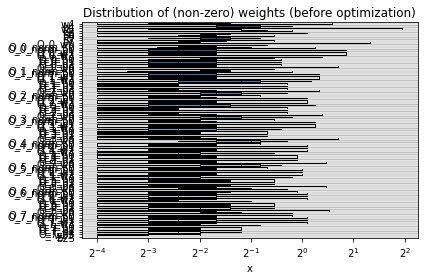

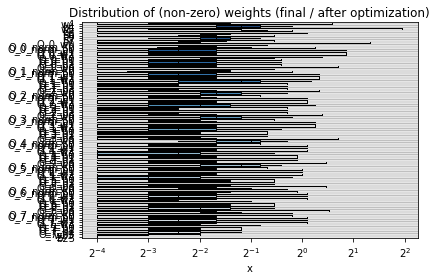

In [31]:
from hls4ml.model.profiling import numerical
import matplotlib.pyplot as plt

# plots = numerical(model=intermediary_model, hls_model = hls_model, X=graphs[0])
# plots = numerical(model=intermediary_model)
plots = numerical(hls_model = hls_model)
# plots = numerical(hls_model = hls_model, X=graphs[0].hls_data)

plt.show()

## hls_model.compile() builds the C-function for the model

In [32]:
hls_model.compile()
# hls_model.build()
"""
compile
build
implementation
"""

Writing HLS project
outputs_str: result_t layer26_out[N_LAYER_25]
layer: <hls4ml.model.hls_layers.Input object at 0x7f089bea73d0>
layer: <hls4ml.model.hls_layers.Input object at 0x7f089bea7610>
layer: <hls4ml.model.hls_layers.Input object at 0x7f089be3b0d0>
layer: <hls4ml.model.hls_layers.NodeEncoder object at 0x7f089be3b2d0>
def_cpp: layer4_t layer4_out[N_LAYER_1_4*N_LAYER_2_4]
layer: <hls4ml.model.hls_layers.EdgeEncoder object at 0x7f089be3b450>
def_cpp: layer5_t layer5_out[N_LAYER_1_5*N_LAYER_2_5]
layer: <hls4ml.model.hls_layers.QuantScaleBias object at 0x7f089be3b8d0>
def_cpp: layer6_t layer6_out[N_LAYER_1_4*N_LAYER_2_4]
layer: <hls4ml.model.hls_layers.QuantScaleBias object at 0x7f089bea7510>
def_cpp: layer7_t layer7_out[N_LAYER_1_5*N_LAYER_2_5]
layer: <hls4ml.model.hls_layers.EdgeAggregate object at 0x7f089be3f3d0>
def_cpp: layer8_t layer8_out[N_NODE*LAYER8_OUT_DIM]
layer: <hls4ml.model.hls_layers.NodeBlock object at 0x7f089be3fb50>
def_cpp: layer9_t layer9_out[N_LAYER_1_4*LAYER9_

'\ncompile\nbuild\nimplementation\n'

# Evaluation and prediction: hls_model.predict(input)

### Data

In [33]:
class data_wrapper(object):
    def __init__(self, node_attr, edge_attr, edge_index, target):
        self.x = node_attr
        self.edge_attr = edge_attr
        self.edge_index = edge_index.transpose(0,1)

        node_attr, edge_attr, edge_index = self.x.detach().cpu().numpy(), self.edge_attr.detach().cpu().numpy(), self.edge_index.transpose(0, 1).detach().cpu().numpy().astype(np.float32)
        node_attr, edge_attr, edge_index = np.ascontiguousarray(node_attr), np.ascontiguousarray(edge_attr), np.ascontiguousarray(edge_index)
        self.hls_data = [node_attr, edge_attr, edge_index]

        self.target = target
        self.np_target = np.reshape(target.detach().cpu().numpy(), newshape=(target.shape[0],))

def load_graphs(graph_indir, graph_dims, n_graphs):
    graph_files = np.array(os.listdir(graph_indir))
    graph_files = np.array([os.path.join(graph_indir, graph_file)
                            for graph_file in graph_files])
    n_graphs_total = len(graph_files)
    IDs = np.arange(n_graphs_total)
    print(f"IDS: {IDs}")
    dataset = GraphDataset(graph_files=graph_files[IDs])

    graphs = []
    for data in dataset[:n_graphs]:
        node_attr, edge_attr, edge_index, target, bad_graph = fix_graph_size(data.x, data.edge_attr, data.edge_index,
                                                                             data.y,
                                                                             n_node_max=graph_dims['n_node'],
                                                                             n_edge_max=graph_dims['n_edge'])
        if not bad_graph:
            graphs.append(data_wrapper(node_attr, edge_attr, edge_index, target))
#         graphs.append(data_wrapper(node_attr, edge_attr, edge_index, target))
    print(f"graphs length: {len(graphs)}")

    print("writing test bench data for 1st graph")
    data = graphs[0]
    node_attr, edge_attr, edge_index = data.x.detach().cpu().numpy(), data.edge_attr.detach().cpu().numpy(), data.edge_index.transpose(
        0, 1).detach().cpu().numpy().astype(np.int32)
    os.makedirs('tb_data', exist_ok=True)
    input_data = np.concatenate([node_attr.reshape(1, -1), edge_attr.reshape(1, -1), edge_index.reshape(1, -1)], axis=1)
    np.savetxt('tb_data/input_data.dat', input_data, fmt='%f', delimiter=' ')

    return graphs


graph_indir = "trackml_data/processed_plus_pyg_small"

graphs = load_graphs(graph_indir, graph_dims, n_graphs=10)

IDS: [0 1 2 3 4 5 6 7 8 9]
graphs length: 2
writing test bench data for 1st graph


In [43]:
"""
Here we are testing hls model output compared to pyg model.
We are using Mean Squared Error (MSE) to calculate the differences 
in the output of the two models.
"""
MSE_l = []
batch = None
siqi_data = None
intermediary_model.to("cpu")
bv_model.to("cpu")
for data in graphs:
    # print(data.x.device)
    intermediary_pred = intermediary_model(data)
    intermediary_pred = intermediary_pred.detach().cpu().numpy().flatten()
    hls_pred = hls_model.predict(data.hls_data)
    siqi_pred = bv_model(
        x = data.x, edge_index = data.edge_index, edge_attr = data.edge_attr, batch = None, data = None
    )
    siqi_pred = siqi_pred.detach().cpu().numpy().flatten()
    print(f"intermediary_pred.shape: {intermediary_pred.shape}")
    print(f"hls_pred.shape: {hls_pred.shape}")
    MSE = mean_squared_error(intermediary_pred, hls_pred)
#     print(np.testing.assert_almost_equal(intermediary_pred, hls_pred))
    print(f"torch vs siqi: {mean_squared_error(intermediary_pred, siqi_pred)}")
    MSE_l.append(MSE)

MSE_l = np.array(MSE_l)
print(f"MSE_l: {MSE_l}")
print(f"Mean of all MSEs: {np.mean(MSE_l)}")

intermediary_pred.shape: (1,)
hls_pred.shape: (1,)
torch vs siqi: 0.0
intermediary_pred.shape: (1,)
hls_pred.shape: (1,)
torch vs siqi: 0.0
MSE_l: [1.1245958e-07 1.1245958e-07]
Mean of all MSEs: 1.1245958120298383e-07


In [46]:
with open('test_data.pickle', 'rb') as f:
    graphs= pkl.load(f) 

MSEs = []
for data in graphs:
    intermediary_pred = intermediary_model(data)
    intermediary_pred = intermediary_pred.detach().cpu().numpy().flatten()
    hls_pred = hls_model.predict(data.hls_data)
    MSE = mean_squared_error(intermediary_pred, hls_pred)
    MSEs.append(MSE)
    bv_pred = bv_model(
        x = data.x, edge_index = data.edge_index, edge_attr = data.edge_attr, batch = None, data = None
    )
    bv_pred = bv_pred.detach().cpu().numpy().flatten()
    print(f"intermediary vs bv: {mean_squared_error(intermediary_pred, bv_pred)}")
    print(f"hls vs bv: {mean_squared_error(hls_pred, bv_pred)}")
    
print(f"MSEs: \n {MSEs}")

intermediary vs bv: 0.0
hls vs bv: 0.9993189573287964
intermediary vs bv: 0.0
hls vs bv: 0.9993189573287964
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 0.9684402346611023
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 0.027780689299106598
intermediary vs bv: 0.0
hls vs bv: 0.9993189573287964
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs bv: 1.1245958120298383e-07
intermediary vs bv: 0.0
hls vs b

In [ ]:
"""
Now let's load some of tau3mu data from our group (Prof Mia Liu).
This is still a smaller sample of the total data, but it's good enough. 

NOTE: this will take some time (<5mins)
"""
import timeit

MSEs = []
stages = ["train", "valid", "test"]
# turn off debugging here
intermediary_model.SetDebugMode(False)

for stage in stages:
    with open(f'tau3mu_data/test_BIG_data_{stage}.pickle', 'rb') as f:
        graphs= pkl.load(f) 
        
    counter = 0
    start = timeit.default_timer()
    for data in graphs:
        # use counter to just keep track of the progress. Nothing fancy
        if counter%500 ==0 and counter != 0:
            print(f"counter: {counter}")
        counter += 1
        intermediary_pred = intermediary_model(data)
        intermediary_pred = intermediary_pred.detach().cpu().numpy()
        hls_pred = hls_model.predict(data.hls_data)
        MSE = mean_squared_error(intermediary_pred, hls_pred)
        MSEs.append(MSE)
    end = timeit.default_timer()
    print(f"time taken: {(end - start)/ 60} mins")
MSEs = np.array(MSEs)
print(f"MSE means: {np.mean(MSEs)}")
print(f"MSE max: {np.max(MSEs)}")
print(f"n_total: {MSEs.shape[0]}")

In [ ]:
"""
Now let's graph the MSE distribution
"""
import numpy as np
import matplotlib.pyplot as plt

n_total = MSEs.shape[0]
mean_val = np.mean(MSEs)

plt.hist(MSEs, density=True, bins=50, label=f"Mean value: {mean_val}\n max val outlier removed") 
plt.ylabel('Occurrence')
plt.xlabel('MSE');
plt.title(f'MSE of hls vs torch prediction (n_total: {n_total})')
plt.legend()
plt.show()
plt.savefig('MSEs.png')

You can see from the graph above that the error is very small (order of magnitude -7). This will obviously get bigger once you use more realistic ap_fixed parameters, but this proves that the conversion itself is working as intended.

So this is the latest progress on the pyg to hls conversion. The current model is only one layer out of eight pyg layers from the original Siqi's model. More work is on the way, but hopefully this gives you a good idea of how the conversion pipeline works. 

For any questions, please email me at yun@purdue.edu, or slack if you already have me on it.
Thank you!

# Biography
This walkthrough and other local files were taken from Mr Abd Elabd's code at https://github.com/abdelabd/manual_GNN_conversion <br />
The hls4ml pyg support's starting code has been taken from Mr. Abd Elabd and Prof Javier Duarte's work: https://github.com/fastmachinelearning/hls4ml/tree/pyg_to_hls_rebase_w_dataflow